In [ ]:
#| default_exp models.bitcn

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# BiTCN

Bidirectional Temporal Convolutional Network (BiTCN) is a forecasting architecture based on two temporal convolutional networks (TCNs). The first network ('forward') encodes future covariates of the time series, whereas the second network ('backward') encodes past observations and covariates. This method allows to preserve the temporal information of sequence data, and is computationally more efficient than common RNN methods (LSTM, GRU, ...). As compared to Transformer-based methods, BiTCN has a lower space complexity, i.e. it requires orders of magnitude less parameters.

This model may be a good choice if you seek a small model (small amount of trainable parameters) with few hyperparameters to tune (only 2).

**References**<br>
-[Olivier Sprangers, Sebastian Schelter, Maarten de Rijke (2023). Parameter-Efficient Deep Probabilistic Forecasting. International Journal of Forecasting 39, no. 1 (1 January 2023): 332–45. URL: https://doi.org/10.1016/j.ijforecast.2021.11.011.](https://doi.org/10.1016/j.ijforecast.2021.11.011)<br>
-[Shaojie Bai, Zico Kolter, Vladlen Koltun. (2018). An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling. Computing Research Repository, abs/1803.01271. URL: https://arxiv.org/abs/1803.01271.](https://arxiv.org/abs/1803.01271)<br>
-[van den Oord, A., Dieleman, S., Zen, H., Simonyan, K., Vinyals, O., Graves, A., Kalchbrenner, N., Senior, A. W., & Kavukcuoglu, K. (2016). Wavenet: A generative model for raw audio. Computing Research Repository, abs/1609.03499. URL: http://arxiv.org/abs/1609.03499. arXiv:1609.03499.](https://arxiv.org/abs/1609.03499)<br>

![Figure 1. Visualization of a stack of dilated causal convolutional layers.](imgs_models/bitcn.png)

In [ ]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

In [ ]:
#| exporti
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_windows import BaseWindows
from neuralforecast.common._modules import RevIN

## 1. Auxiliary Functions

In [ ]:
#| export
class CustomConv1d(nn.Module):
    """
    Forward- and backward looking Conv1D
    """
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, dilation=1, mode='backward', groups=1):
        super().__init__()
        k = np.sqrt(1 / (in_channels * kernel_size))
        weight_data = -k + 2 * k * torch.rand((out_channels, in_channels // groups, kernel_size))
        bias_data = -k + 2 * k * torch.rand((out_channels))
        self.weight = nn.Parameter(weight_data, requires_grad=True)
        self.bias = nn.Parameter(bias_data, requires_grad=True)  
        self.dilation = dilation
        self.groups = groups
        if mode == 'backward':
            self.padding_left = padding
            self.padding_right= 0
        elif mode == 'forward':
            self.padding_left = 0
            self.padding_right= padding            

    def forward(self, x):
        xp = F.pad(x, (self.padding_left, self.padding_right))
        return F.conv1d(xp, self.weight, self.bias, dilation=self.dilation, groups=self.groups)

class TCNCell(nn.Module):
    """
    Temporal Convolutional Network Cell, consisting of CustomConv1D modules.
    """    
    def __init__(self, in_channels, hidden_channels, out_channels, kernel_size, padding, dilation, mode, groups, dropout):
        super().__init__()
        self.conv1 = CustomConv1d(in_channels, hidden_channels, kernel_size, padding, dilation, mode, groups)
        self.conv2 = CustomConv1d(hidden_channels, hidden_channels + out_channels, 1)
        self.drop = nn.Dropout(dropout)
        self.hidden_channels = hidden_channels
        
    def forward(self, x):
        h_prev, out_prev = x
        h = self.drop(F.gelu(self.conv1(h_prev)))
        h = self.conv2(h)
        h_next = h[:, :self.hidden_channels]
        out_next = h[:, self.hidden_channels:]

        return (h_prev + h_next, out_prev + out_next)
    
class MLPResidual(nn.Module):
    """
    MLPResidual
    """

    def __init__(self, input_dim, hidden_size, output_dim, dropout, layernorm):
        super().__init__()
        self.layernorm = layernorm
        if layernorm:
            self.norm = nn.LayerNorm(output_dim)

        self.drop = nn.Dropout(dropout)
        self.lin1 = nn.Linear(input_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, output_dim)
        self.skip = nn.Linear(input_dim, output_dim)

    def forward(self, input):
        # MLP dense
        x = F.gelu(self.lin1(input))
        x = self.drop(x)
        x = self.lin2(x)

        # Skip connection
        x_skip = self.skip(input)

        # Combine
        x = x + x_skip

        if self.layernorm:
            return self.norm(x)

        return x    

## 2. BiTCN

In [ ]:
#| export
class BiTCN(BaseWindows):
    """ BiTCN

    Bidirectional Temporal Convolutional Network (BiTCN) is a forecasting architecture based on two temporal convolutional networks (TCNs). The first network ('forward') encodes future covariates of the time series, whereas the second network ('backward') encodes past observations and covariates. This is a univariate model.

    **Parameters:**<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, considered autorregresive inputs (lags), y=[1,2,3,4] input_size=2 -> lags=[1,2].<br>
    `hidden_size`: int=16, units for the TCN's hidden state size.<br>
    `dropout`: float=0.1, dropout rate used for the dropout layers throughout the architecture.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
    `windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
    `inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
    `start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
    `optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
    `lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
    `lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>
    `dataloader_kwargs`: dict, optional, list of parameters passed into the PyTorch Lightning dataloader by the `TimeSeriesDataLoader`. <br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

    **References**<br>  
    - [Olivier Sprangers, Sebastian Schelter, Maarten de Rijke (2023). Parameter-Efficient Deep Probabilistic Forecasting. International Journal of Forecasting 39, no. 1 (1 January 2023): 332–45. URL: https://doi.org/10.1016/j.ijforecast.2021.11.011.](https://doi.org/10.1016/j.ijforecast.2021.11.011)<br>    

    """
    # Class attributes
    SAMPLING_TYPE = 'windows'
    EXOGENOUS_FUTR = False
    EXOGENOUS_HIST = False
    EXOGENOUS_STAT = False

    def __init__(self,
                 h: int,
                 input_size: int,
                 hidden_size: int = 16,
                 dropout: float = 0.5,
                 init_forecast: str = "zero",
                 deepnpts_n_layers: int = 2,
                 deepnpts_batch_norm: bool = True,
                 revin: bool = False,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 exclude_insample_y = False,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size = 1024,
                 inference_windows_batch_size = 1024,
                 start_padding_enabled = False,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 drop_last_loader: bool = False,
                 optimizer = None,
                 optimizer_kwargs = None,
                 lr_scheduler = None,
                 lr_scheduler_kwargs = None,
                 dataloader_kwargs=None,
                 **trainer_kwargs):
        super(BiTCN, self).__init__(
            h=h,
            input_size=input_size,
            futr_exog_list=futr_exog_list,
            hist_exog_list=hist_exog_list,
            stat_exog_list=stat_exog_list,
            exclude_insample_y = exclude_insample_y,
            loss=loss,
            valid_loss=valid_loss,
            max_steps=max_steps,
            learning_rate=learning_rate,
            num_lr_decays=num_lr_decays,
            early_stop_patience_steps=early_stop_patience_steps,
            val_check_steps=val_check_steps,
            batch_size=batch_size,
            valid_batch_size=valid_batch_size,
            windows_batch_size=windows_batch_size,
            inference_windows_batch_size=inference_windows_batch_size,
            start_padding_enabled=start_padding_enabled,
            step_size=step_size,
            scaler_type=scaler_type,
            random_seed=random_seed,
            drop_last_loader=drop_last_loader,
            optimizer=optimizer,
            optimizer_kwargs=optimizer_kwargs,
            lr_scheduler=lr_scheduler,
            lr_scheduler_kwargs=lr_scheduler_kwargs,
            dataloader_kwargs=dataloader_kwargs,
            **trainer_kwargs
        )

        #----------------------------------- Parse dimensions -----------------------------------#
        # TCN
        kernel_size = 2  # Not really necessary as parameter, so simplifying the architecture here.
        self.kernel_size = kernel_size
        self.hidden_size = hidden_size
        self.h = h
        self.input_size = input_size
        self.dropout = dropout
        self.init_forecast = init_forecast
        
        # Calculate required number of TCN layers based on the required receptive field of the TCN
        self.n_layers_bwd = int(np.ceil(np.log2(((self.input_size - 1) / (self.kernel_size - 1)) + 1)))     
        self.n_layers_fwd = int(np.ceil(np.log2(((self.h - 1) / (self.kernel_size - 1)) + 1)))     
       
        #---------------------------------- Instantiate Model -----------------------------------#
        
        # Dense layers
        self.lin_hist = nn.Linear(1, hidden_size)
        self.drop_hist = nn.Dropout(dropout)
        
        # TCN encoder
        enc_layers_bwd = [TCNCell(
                        hidden_size, 
                        hidden_size, 
                        hidden_size,
                        kernel_size, 
                        padding = (kernel_size-1)*2**i, 
                        dilation = 2**i, 
                        mode = 'backward', 
                        groups = 1, 
                        dropout = dropout) for i in range(self.n_layers_bwd)]      
        enc_layers_fwd = [TCNCell(
                        hidden_size, 
                        hidden_size, 
                        hidden_size,
                        kernel_size, 
                        padding = (kernel_size-1)*2**i, 
                        dilation = 2**i, 
                        mode = 'forward', 
                        groups = 1, 
                        dropout = dropout) for i in range(self.n_layers_bwd)]      

        self.encoder = nn.Sequential(*enc_layers_bwd, *enc_layers_fwd)

        lin_temp = [nn.Linear(input_size, hidden_size),
                    nn.Linear(hidden_size, h)]
        self.lin_temp = nn.Sequential(*lin_temp)

        if self.init_forecast == "deepnpts":
            # Create DeepNPTSNetwork
            modules = []       
            deepnpts_n_layers = 2
            deepnpts_batch_norm = True
            for i in range(deepnpts_n_layers):
                modules.append(nn.Linear(input_size if i == 0 else hidden_size, hidden_size))
                modules.append(nn.ReLU())
                if deepnpts_batch_norm:
                    modules.append(nn.BatchNorm1d(hidden_size))
                if dropout > 0.0:
                    modules.append(nn.Dropout(dropout))

            modules.append(nn.Linear(hidden_size, input_size * self.h))
            self.deepnptsnetwork = nn.Sequential(*modules)

        # TCN looking forward
        dec_layers_fwd = [TCNCell(
                        hidden_size, 
                        hidden_size,
                        self.loss.outputsize_multiplier, 
                        kernel_size, 
                        padding = (kernel_size-1)*2**i, 
                        dilation = 2**i, 
                        mode = 'forward', 
                        groups = 1, 
                        dropout = dropout) for i in range(self.n_layers_fwd)]      
        dec_layers_bwd = [TCNCell(
                        hidden_size, 
                        hidden_size,
                        self.loss.outputsize_multiplier, 
                        kernel_size, 
                        padding = (kernel_size-1)*2**i, 
                        dilation = 2**i, 
                        mode = 'backward', 
                        groups = 1, 
                        dropout = dropout) for i in range(self.n_layers_fwd)] 
        self.decoder = nn.Sequential(*dec_layers_bwd, *dec_layers_fwd)

        self.revin = revin
        if self.revin:
            self.revin_layer = RevIN(1, affine=False)


    def forward(self, windows_batch):
        # Parse windows_batch
        insample_y    = windows_batch['insample_y'] 
        x             = insample_y.unsqueeze(-1)                        #   [B, L, 1]
        batch_size, seq_len = x.shape[:2]                               #   B = batch_size, L = seq_len

        if self.revin:
            x = self.revin_layer(x, mode="norm")                                                   
        
        # Apply backward TCN to x
        x = self.drop_hist(self.lin_hist(x))                            #   [B, L, 1] -> [B, L, hidden_size]
        x = x.permute(0, 2, 1)                                          #   [B, L, hidden_size] -> [B, hidden_size, L]
        _, x = self.encoder((x, 0))                                     #   [B, hidden_size, L] -> [B, hidden_size, L]

        # Create forecast
        x = self.lin_temp(x)                                            #   [B, hidden_size, L] -> [B, hidden_size, h]

        if self.init_forecast == "deepnpts":
            # Run through DeepNPTSNetwork
            weights = self.deepnptsnetwork(insample_y)                      #   [B, L]  -> [B, L * h]

            # Apply softmax for weighted input predictions
            weights = weights.reshape(batch_size, seq_len, -1)              #   [B, L * h] -> [B, L, h]
            x0 = F.softmax(weights, dim=1) * insample_y.unsqueeze(-1)        #   [B, L, h] * [B, L, 1] = [B, L, h]
            x0 = torch.sum(x0, dim=1, keepdim=True)                          #   [B, L, h] -> [B, 1, h]
        elif self.init_forecast == "mean":   
            x0 = torch.mean(insample_y, dim=1, keepdim=True)                #   [B, L] -> [B, 1]
            x0 = x0.unsqueeze(-1)
            x0 = x0.repeat(1, 1, self.h)                                    #   [B, 1, 1] -> [B, 1, h]
        elif self.init_forecast == "zero":
            x0 = 0
        elif self.init_forecast == "naive":
            x0 = insample_y[:, -1].unsqueeze(-1).unsqueeze(-1)              #   [B, L] -> [B, 1, 1]
            x0 = x0.repeat(1, 1, self.h)                                    #   [B, 1, 1] -> [B, 1, h]

        # Apply forward TCN to x
        _, fcst = self.decoder((x, x0))                                  #   [B, hidden_size, h] -> [B, n_outputs, h]
        fcst = fcst.permute(0, 2, 1)                                      #   [B, n_outputs, h] -> [B, h, n_outputs]

        if self.revin:
            fcst = self.revin_layer(fcst, mode="denorm")              #   [B, h, n_outputs] -> [B, h, n_outputs]


        # Map to output domain
        forecast = self.loss.domain_map(fcst)
        
        return forecast

In [ ]:
show_doc(BiTCN)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/bitcn.py#L127){target="_blank" style="float:right; font-size:smaller"}

### BiTCN

>      BiTCN (h:int, input_size:int, hidden_size:int=16, dropout:float=0.5,
>             init_forecast:str='zero', deepnpts_n_layers:int=2,
>             deepnpts_batch_norm:bool=True, revin:bool=False,
>             futr_exog_list=None, hist_exog_list=None, stat_exog_list=None,
>             exclude_insample_y=False, loss=MAE(), valid_loss=None,
>             max_steps:int=1000, learning_rate:float=0.001,
>             num_lr_decays:int=-1, early_stop_patience_steps:int=-1,
>             val_check_steps:int=100, batch_size:int=32,
>             valid_batch_size:Optional[int]=None, windows_batch_size=1024,
>             inference_windows_batch_size=1024, start_padding_enabled=False,
>             step_size:int=1, scaler_type:str='identity', random_seed:int=1,
>             drop_last_loader:bool=False, optimizer=None,
>             optimizer_kwargs=None, lr_scheduler=None,
>             lr_scheduler_kwargs=None, dataloader_kwargs=None,
>             **trainer_kwargs)

*BiTCN

Bidirectional Temporal Convolutional Network (BiTCN) is a forecasting architecture based on two temporal convolutional networks (TCNs). The first network ('forward') encodes future covariates of the time series, whereas the second network ('backward') encodes past observations and covariates. This is a univariate model.

**Parameters:**<br>
`h`: int, forecast horizon.<br>
`input_size`: int, considered autorregresive inputs (lags), y=[1,2,3,4] input_size=2 -> lags=[1,2].<br>
`hidden_size`: int=16, units for the TCN's hidden state size.<br>
`dropout`: float=0.1, dropout rate used for the dropout layers throughout the architecture.<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int=1000, maximum number of training steps.<br>
`learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
`num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
`val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
`batch_size`: int=32, number of different series in each batch.<br>
`valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
`windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
`inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
`start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
`step_size`: int=1, step size between each window of temporal data.<br>
`scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`alias`: str, optional,  Custom name of the model.<br>
`optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
`optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
`lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
`lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>
`dataloader_kwargs`: dict, optional, list of parameters passed into the PyTorch Lightning dataloader by the `TimeSeriesDataLoader`. <br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

**References**<br>  
- [Olivier Sprangers, Sebastian Schelter, Maarten de Rijke (2023). Parameter-Efficient Deep Probabilistic Forecasting. International Journal of Forecasting 39, no. 1 (1 January 2023): 332–45. URL: https://doi.org/10.1016/j.ijforecast.2021.11.011.](https://doi.org/10.1016/j.ijforecast.2021.11.011)<br>*

In [ ]:
show_doc(BiTCN.fit, name='BiTCN.fit')

---

### BiTCN.fit

>      BiTCN.fit (dataset, val_size=0, test_size=0, random_seed=None,
>                 distributed_config=None)

*Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`test_size`: int, test size for temporal cross-validation.<br>*

In [ ]:
show_doc(BiTCN.predict, name='BiTCN.predict')

---

### BiTCN.predict

>      BiTCN.predict (dataset, test_size=None, step_size=1, random_seed=None,
>                     **data_module_kwargs)

*Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).*

## Usage Example

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | GMM           | 5      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | lin_hist     | Linear        | 32     | train
4 | drop_hist    | Dropout       | 0      | train
5 | encoder      | Sequential    | 10.7 K | train
6 | lin_temp     | Sequential    | 604    | train
7 | decoder      | Sequential    | 8.3 K  | train
-------------------------------------------------------
19.7 K    Trainable params
5         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
82        Modules in train mode
0         Modules in eval mode


Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 23.05it/s, v_num=9791, train_loss_step=3.670, train_loss_epoch=3.670, valid_loss=5.000]

c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.68it/s]


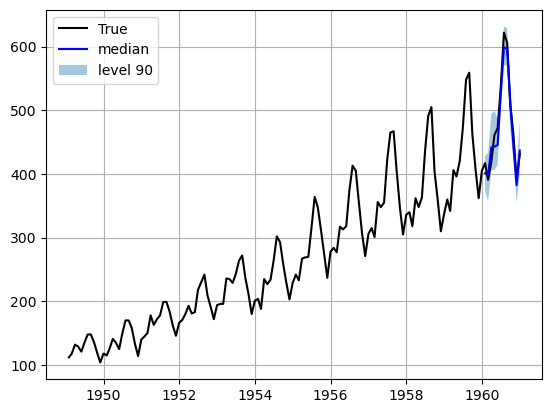

In [ ]:
#| eval: false
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
# from neuralforecast.models import BiTCN
from neuralforecast.losses.pytorch import HuberLoss, GMM
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

fcst = NeuralForecast(
    models=[
            BiTCN(h=12,
                input_size=24,
                loss=GMM(n_components=7, return_params=True, level=[80,90]),
                # loss = HuberLoss(),
                max_steps=1000,
                scaler_type='robust',
                # hidden_size=128,
                # dropout=0.,
                # futr_exog_list=['y_[lag12]'],
                # hist_exog_list=None,
                # stat_exog_list=['airline1'],
                # init_forecast = "zero"
                early_stop_patience_steps=3,
                # patch_len = 8,	
                ),     
    ],
    freq='M'
)
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
# plt.plot(plot_df['ds'], plot_df['BiTCN'], c='blue', label='median')
plt.plot(plot_df['ds'], plot_df['BiTCN-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:], 
                 y1=plot_df['BiTCN-lo-90'][-12:].values,
                 y2=plot_df['BiTCN-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()